In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from torch.utils.data import Dataset
import os
import tifffile as tiff
import numpy as np
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

from collections import Counter
import numpy as np
from scipy.stats import mode

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize


In [2]:
class ImageDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_files = []
        self.labels = []
        self.class_names = []  # To store class (folder) names
        self.class_to_idx = {}  # To map class names to indices
        self.class_counts = {}  # To store count of images per class

        # Define a transformation to resize the images
        self.transform = transforms.Compose([transforms.Resize((96, 96))])

        # Get all subdirectories (classes)
        self.class_names = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]
        self.class_names.sort()  # Ensure consistent ordering
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.class_names)}

        # Load images and assign labels based on folder name
        for class_name in self.class_names:
            class_dir = os.path.join(image_dir, class_name)
            class_images = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith('.tiff')]
            self.image_files.extend(class_images)
            self.labels.extend([self.class_to_idx[class_name]] * len(class_images))  # Assign class index as label
            
            # Store the count of images per class
            self.class_counts[class_name] = len(class_images)

        # Print labels and counts
        self.print_labels_and_counts()
     
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.labels[idx]

        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        original_image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor 
        image = torch.tensor(original_image, dtype=torch.float32)
        #print(image.shape)
        # Apply the resizing transform (resize)
        image = self.transform(image)

        flattened_image = image.view(-1).numpy()  # Reshape to (96*96*3, )
        
        return flattened_image, label

    def print_labels_and_counts(self):
        print("Class Labels and Counts:")
        for class_name, class_index in self.class_to_idx.items():
            print(f"Class '{class_name}' (Index {class_index}): {self.class_counts[class_name]} images")


# Example usage
image_dir = r'..\..\..\Data_supervised'  # Replace with your image directory
dataset = ImageDataset(image_dir)  # Initialize dataset, it will automatically print labels and counts


Class Labels and Counts:
Class 'single_dose' (Index 0): 30 images
Class 'untreated' (Index 1): 30 images


In [4]:
for i in range(len(dataset)):
    falttened_image,l = dataset[i]
    print(falttened_image.shape)  # This will print the shape of each image
    break

(27648,)


In [5]:
# Combine all images into a single dataset for K-Means input
def load_image_data(dataset):
    all_images = []
    all_labels = []
    
    for i in range(len(dataset)):
        flattened_image, label = dataset[i]  # Unpack the image and label
        all_images.append(flattened_image)
        all_labels.append(label)
    
    # Stack all the flattened images to create a large dataset
    X = np.vstack(all_images)  # Combine all images into a single dataset (60,96*96*3)

    # Normalize the combined dataset along the features axis (axis=1)
    return X, np.array(all_labels)

In [6]:
# Main function to run the K-Means algorithm
X, labels = load_image_data(dataset)  # Load data and labels 
print(X.shape)
print(labels.shape)

(60, 27648)
(60,)


In [7]:
# Define KMeansCosine class
class KMeansCosine:
    def __init__(self, n_clusters=2, max_iter=300, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

    def fit(self, X):
        # Normalize the data to unit vectors
        X_normalized = X / np.linalg.norm(X, axis=1)[:, np.newaxis]

        # Initialize centroids randomly from the data points
        np.random.seed(self.random_state)
        initial_indices = np.random.choice(X_normalized.shape[0], self.n_clusters, replace=False)
        centroids = X_normalized[initial_indices]

        # Track the minimum cost and corresponding labels/centroids
        best_cost = float('inf')
        best_labels = None
        best_centroids = None


        for _ in range(self.max_iter):
            # Compute the cosine similarity and distance
            similarities = cosine_similarity(X_normalized, centroids)
            cosine_dist = 1 - similarities
            cost = np.sum(cosine_dist)
            print(f"Iteration cost: {cost}")

            # Update best cost and corresponding labels/centroids if the current cost is lower
            if cost < best_cost:
                best_cost = cost
                best_labels = np.argmax(similarities, axis=1)
                best_centroids = centroids.copy()

            # Assign clusters based on the highest similarity (lowest distance)
            labels = np.argmax(similarities, axis=1)

            # Update centroids by taking the mean of the points in each cluster
            new_centroids = np.array([X_normalized[labels == i].mean(axis=0) for i in range(self.n_clusters)])
            new_centroids /= np.linalg.norm(new_centroids, axis=1)[:, np.newaxis]

            # Check for convergence (if centroids do not change)
            if np.allclose(centroids, new_centroids, atol=1e-6):  # Use np.allclose for numerical stability
                break

            centroids = new_centroids

        # Store final centroids and labels
        self.labels_ = labels
        self.centroids_ = centroids
        self.best_labels_ = best_labels
        self.best_centroids_ = best_centroids
        self.best_cost_ = best_cost

# Define KMeansCosine class
class KMeansCosine:
    def __init__(self, n_clusters=2, max_iter=300, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

    def fit(self, X):
        X_normalized = X / np.linalg.norm(X, axis=1)[:, np.newaxis]
        np.random.seed(self.random_state)
        initial_indices = np.random.choice(X_normalized.shape[0], self.n_clusters, replace=False)
        centroids = X_normalized[initial_indices]

        for _ in range(self.max_iter):
            similarities = cosine_similarity(X_normalized, centroids)
            cosine_dist = 1-similarities
            cost = np.sum(cosine_dist)
            print(cost)
            labels = np.argmax(similarities, axis=1)
            new_centroids = np.array([X_normalized[labels == i].mean(axis=0) for i in range(self.n_clusters)])
            new_centroids /= np.linalg.norm(new_centroids, axis=1)[:, np.newaxis]

            if np.all(centroids == new_centroids):
                break

            centroids = new_centroids

        self.labels_ = labels
        self.centroids_ = centroids

In [8]:
kmeans_cosine = KMeansCosine(n_clusters=2,max_iter=100, random_state=30)
kmeans_cosine.fit(X)

print("Final Cluster Labels:", kmeans_cosine.labels_)
print("Final Centroids:", kmeans_cosine.centroids_)
print("Best Cluster Labels with Lowest Cost:", kmeans_cosine.best_labels_)
print("Best Centroids with Lowest Cost:", kmeans_cosine.best_centroids_)
print("Lowest Cost:", kmeans_cosine.best_cost_)

Iteration cost: 2.2641522884368896
Iteration cost: 1.1628772020339966
Iteration cost: 1.3781492710113525
Iteration cost: 1.3323874473571777
Iteration cost: 1.302980899810791
Iteration cost: 1.2910981178283691
Final Cluster Labels: [0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Final Centroids: [[0.0068018  0.00683331 0.00686134 ... 0.00714206 0.00715319 0.00715223]
 [0.00671632 0.00673036 0.00674321 ... 0.00665582 0.00666384 0.00665839]]
Best Cluster Labels with Lowest Cost: [1 0 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Best Centroids with Lowest Cost: [[0.00675401 0.00677547 0.00679646 ... 0.00695177 0.00695192 0.0069415 ]
 [0.0067614  0.00678203 0.00680031 ... 0.0068358  0.00684663 0.00684406]]
Lowest Cost: 1.1628772


In [9]:
best_centroids = kmeans_cosine.best_centroids_
best_centroids

array([[0.00675401, 0.00677547, 0.00679646, ..., 0.00695177, 0.00695192,
        0.0069415 ],
       [0.0067614 , 0.00678203, 0.00680031, ..., 0.0068358 , 0.00684663,
        0.00684406]], dtype=float32)

In [10]:
centroids = kmeans_cosine.centroids_
centroids

array([[0.0068018 , 0.00683331, 0.00686134, ..., 0.00714206, 0.00715319,
        0.00715223],
       [0.00671632, 0.00673036, 0.00674321, ..., 0.00665582, 0.00666384,
        0.00665839]], dtype=float32)

In [11]:
idx = kmeans_cosine.labels_
idx

array([0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [12]:
print("Cluster assignments:", idx)
print("True labels:", labels)

Cluster assignments: [0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [13]:
best_idx = kmeans_cosine.best_labels_

In [14]:
print("Cluster assignments:", best_idx)
print("True labels:", labels)

Cluster assignments: [1 0 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [15]:
# `idx` contains the cluster assignments from KMeans
#  `labels` contains the true labels

K = len(np.unique(idx))  # Number of clusters

# Iterate over each cluster and count the true labels in that cluster
for cluster in range(K):
    # Find the indices of images assigned to the current cluster
    cluster_indices = np.where(idx == cluster)[0]
    
    # Get the true labels for the images in this cluster
    cluster_labels = labels[cluster_indices]
    
    # Use Counter to count occurrences of each label in the cluster
    label_counts = Counter(cluster_labels)
    
    # Print the result
    print(f"Cluster {cluster} has true labels: {label_counts}")


Cluster 0 has true labels: Counter({0: 23})
Cluster 1 has true labels: Counter({1: 30, 0: 7})


In [16]:
K = len(np.unique(best_idx))  # Number of clusters

# Iterate over each cluster and count the true labels in that cluster
for cluster in range(K):
    # Find the indices of images assigned to the current cluster
    cluster_indices = np.where(best_idx == cluster)[0]
    
    # Get the true labels for the images in this cluster
    cluster_labels = labels[cluster_indices]
    
    # Use Counter to count occurrences of each label in the cluster
    label_counts = Counter(cluster_labels)
    
    # Print the result
    print(f"Cluster {cluster} has true labels: {label_counts}")

Cluster 0 has true labels: Counter({0: 12})
Cluster 1 has true labels: Counter({1: 30, 0: 18})


In [17]:
# Function to reorder K-Means labels to match true labels
def reorder_labels(true_labels, predicted_labels):
    reordered_labels = np.zeros_like(predicted_labels)

    for cluster in np.unique(predicted_labels):
        mask = (predicted_labels == cluster)
        # Use mode and handle cases where mode() returns a scalar
        most_common_label = mode(true_labels[mask], axis=None).mode  # Get the mode for the current cluster
        if isinstance(most_common_label, np.ndarray):
            most_common_label = most_common_label[0]  # Safely extract the mode value if it's an array
        
        reordered_labels[mask] = most_common_label

    return reordered_labels


In [18]:
# Apply this after running K-Means
reordered_idx = reorder_labels(labels, idx)

# Now you can compare `reordered_idx` with `labels` to evaluate accuracy
accuracy = np.sum(reordered_idx == labels) / len(labels) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 88.33%


In [19]:
# Apply this after running K-Means
reordered_idx = reorder_labels(labels, best_idx)

# Now you can compare `reordered_idx` with `labels` to evaluate accuracy
accuracy = np.sum(reordered_idx == labels) / len(labels) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 70.00%


In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [19]:
# Function to reduce the dimensionality of data points and centroids to 2D using PCA
def reduce_to_2D_pca(X, centroids):
    # Initialize PCA with 2 components
    pca = PCA(n_components=2)
    
    # Apply PCA to the data points (X) and centroids
    X_2D = pca.fit_transform(X)  # Reducing original data points
    centroids_2D = pca.transform(centroids)  # Reducing centroids

    return X_2D, centroids_2D

# Function to plot 2D visualization of clustered data points and centroids with true labels
def plot_2D_clusters_with_labels(X_2D, centroids_2D, idx, labels, K):
    plt.figure(figsize=(10, 7))
    
    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))
    
    # Plot data points colored by their cluster assignment
    for k in range(K):
        cluster_points = X_2D[idx == k]
        cluster_labels = labels[idx == k]  # Get true labels for the current cluster
        
        # Scatter plot for each cluster
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6)
        
        # Annotate each point with its true label
        for i in range(cluster_points.shape[0]):
            plt.annotate(str(cluster_labels[i]), 
                         (cluster_points[i, 0], cluster_points[i, 1]), 
                         fontsize=8, alpha=0.75)

    # Plot centroids as larger markers
    plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], 
                c='k', marker='x', s=200, label='Centroids')

    plt.title("2D Visualization of Clusters using PCA with True Labels")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid()
    plt.show()


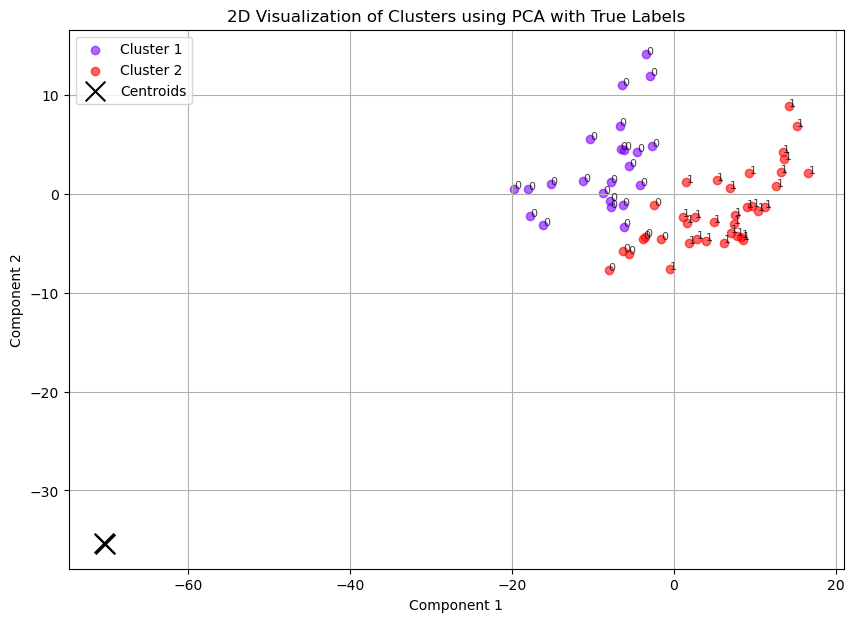

In [24]:
# Apply PCA after K-Means clustering for 2D visualization
X_2D_pca, centroids_2D_pca = reduce_to_2D_pca(X, centroids)

# Plot the 2D clusters with centroids and true labels
plot_2D_clusters_with_labels(X_2D_pca, centroids_2D_pca, idx, labels, K)


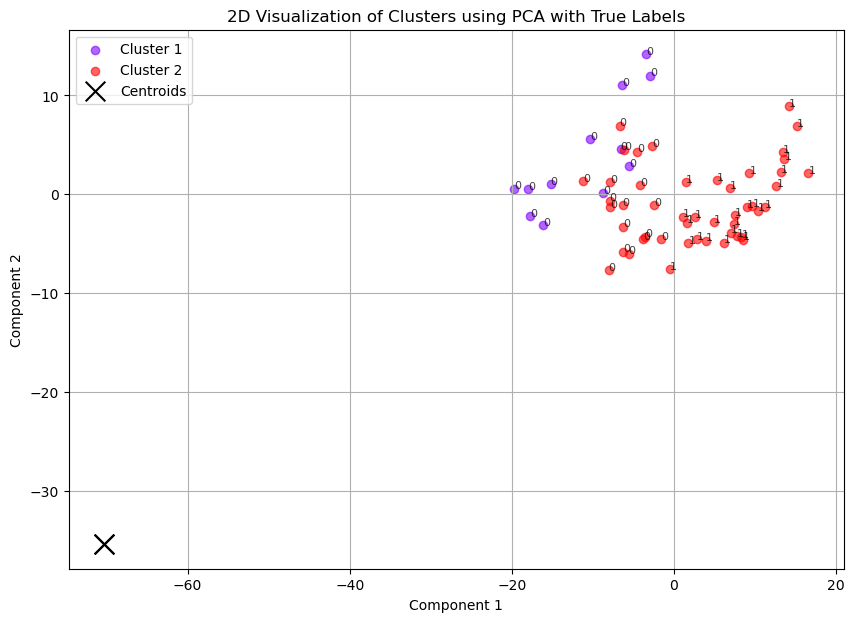

In [25]:
# Apply PCA after K-Means clustering for 2D visualization
X_2D_pca, centroids_2D_pca = reduce_to_2D_pca(X, best_centroids)

# Plot the 2D clusters with centroids and true labels
plot_2D_clusters_with_labels(X_2D_pca, centroids_2D_pca, best_idx, labels, K)


In [22]:
total_data_points = 30+30+12
wrong = 3 
predicted_corrected = total_data_points - wrong
accuracy = (predicted_corrected/total_data_points)*100
print(accuracy)

95.83333333333334


In [45]:
bibi = np.array([
    [0.6394, 0.64353806, 0.64770716, 0.68035775, 0.68076485, 0.68122697],
    [0.6434593, 0.64427465, 0.6459859, 0.6629785, 0.6606025, 0.65433437],
    [0.6341258, 0.63328487, 0.62688166, 0.6681404, 0.66825783, 0.6676554],
    [0.627638, 0.6284246, 0.6292516, 0.61081785, 0.6114242, 0.6106233],
    [0.63396144, 0.63511825, 0.6288564, 0.6226765, 0.6219877, 0.62269145],
    [0.6106442, 0.61703616, 0.6183802, 0.616232, 0.6164079, 0.6152731],
    [0.6106442, 0.61703616, 0.6183802, 0.616232, 0.6164079, 0.6152731]
])

In [47]:
bibi.shape[0]

7

In [2]:
class ImageDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')] 
        
        # Define a transformation to resize the images
        self.transform = transforms.Compose([transforms.Resize((256, 256))])
     
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        original_image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor 
        image = torch.tensor(original_image, dtype=torch.float32)

        # Apply the resizing transform
        image = self.transform(image)

        image_numpy = image.numpy()

        return image_numpy, original_image


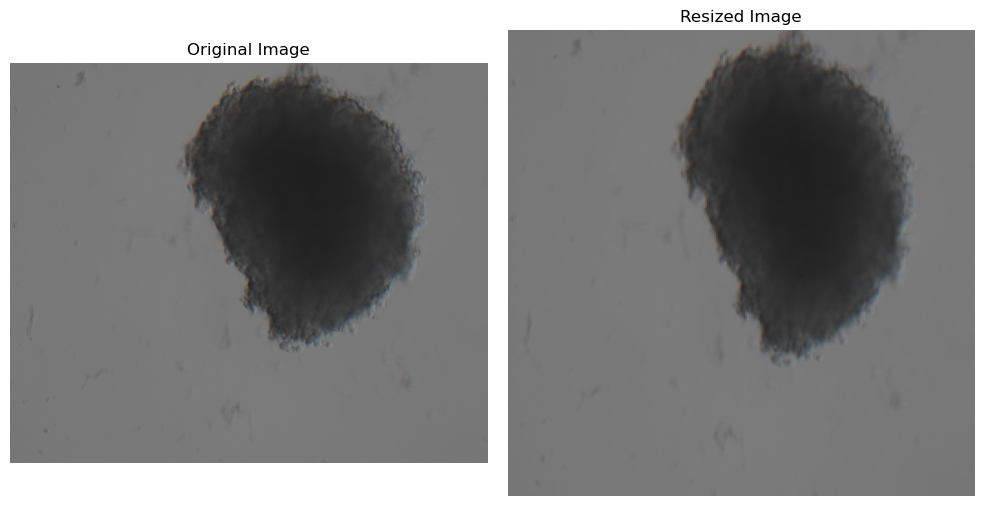

In [3]:
# Create dataset and visualize images
dataset = ImageDataset(r"../../tiff_experiment_unsupervised_data/combined")
for i in range(len(dataset)):
    image_numpy, original_image = dataset[i]  # This will get the resized and original images

    # Plot the original and resized images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display original image
    axes[0].imshow(original_image.transpose(1, 2, 0))  # Change shape for imshow (H, W, C)
    axes[0].set_title('Original Image')
    axes[0].axis('off')  # Turn off axis

    # Display resized image
    axes[1].imshow(image_numpy.transpose(1, 2, 0))  # Change shape for imshow (H, W, C)
    axes[1].set_title('Resized Image')
    axes[1].axis('off')  # Turn off axis

    plt.tight_layout()
    plt.show()

    break  

In [6]:
class ImageData(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')] 
        
        # Define a transformation to resize the images (Note: Resize expects a PIL image or torchvision tensor)
        self.transform = transforms.Resize((256, 256))
     
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Print the shape of the loaded image
        print(f"Image {img_path} loaded with shape: {image.shape}")

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        original_image = image.astype(np.float32) / 65535.0
        print(original_image.shape)
        # Convert to a torch tensor 
        image = torch.tensor(original_image, dtype=torch.float32)
        print(f"tensor image {image.shape}")
        # Apply resizing using torch.nn.functional.interpolate
        image = F.interpolate(image.unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0)

        image_numpy = image.numpy()

        # Flatten the resized image for K-Means input (reshape into (3, 256*256))
        #reshaped_image = image.view(3, -1).T  # Reshape to (256*256, 3)
        #print(f"Reshaped image shape: {reshaped_image.shape}")

        return original_image, image_numpy

Image ../../tiff_experiment_unsupervised_data/combined\1.tiff loaded with shape: (3, 2054, 2456)
(3, 2054, 2456)
tensor image torch.Size([3, 2054, 2456])


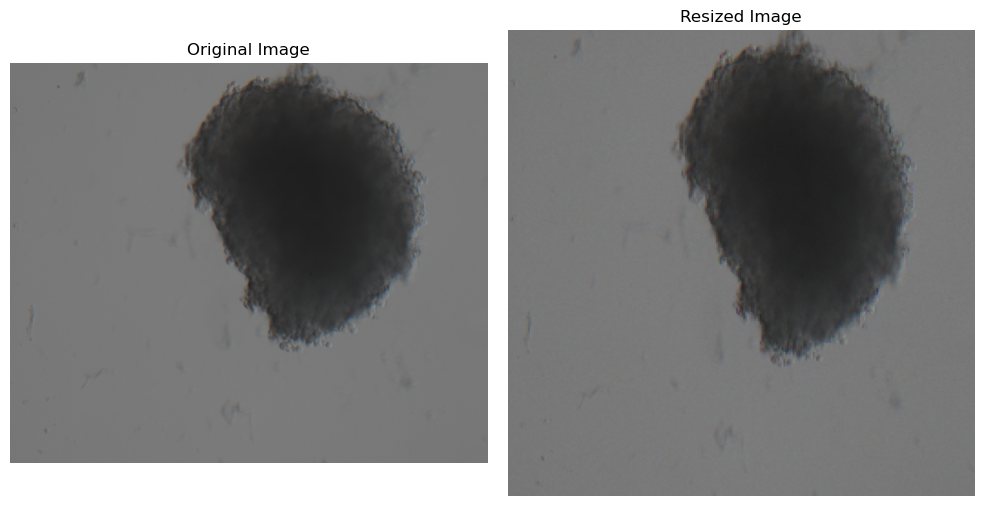

In [7]:
# Create dataset and visualize images
dataset = ImageData(r"../../tiff_experiment_unsupervised_data/combined")
for i in range(len(dataset)):
    orig_image, image_np = dataset[i]  # This will get the resized and original images

    # Plot the original and resized images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display original image
    axes[0].imshow(orig_image.transpose(1, 2, 0))  # Change shape for imshow (H, W, C)
    axes[0].set_title('Original Image')
    axes[0].axis('off')  # Turn off axis

    # Display resized image
    axes[1].imshow(image_np.transpose(1, 2, 0))  # Change shape for imshow (H, W, C)
    axes[1].set_title('Resized Image')
    axes[1].axis('off')  # Turn off axis

    plt.tight_layout()
    plt.show()

    break  

In [9]:
image = tiff.imread(r'C:\Users\k54739\Bibin Babu\thesis\Data_supervised\drug_screened\B02-T01.tiff')

# Print the shape of the loaded image
print(f"Image shape {image.shape}")

# Ensure the image has 3 layers (channels)
if image.shape[0] != 3:
    raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
# Normalize the 16-bit image to [0, 1]
original_image = image.astype(np.float32) / 65535.0
print(original_image.shape)
# Convert to a torch tensor 
image = torch.tensor(original_image, dtype=torch.float32)




Image shape (3, 2054, 2456)
(3, 2054, 2456)


In [15]:
def resize_with_aspect_ratio(image, target_size):
    # Calculate the target size maintaining aspect ratio
    h, w = image.shape[1], image.shape[2]
    aspect_ratio = w / h
    
    if aspect_ratio > 1:  # Wider than tall
        new_width = target_size
        new_height = int(target_size / aspect_ratio)
    else:  # Taller than wide
        new_height = target_size
        new_width = int(target_size * aspect_ratio)

    resized_image = F.interpolate(image.unsqueeze(0), size=(new_height, new_width), mode='bilinear', align_corners=False).squeeze(0)
    
    # Pad to the target size if necessary
    padded_image = F.pad(resized_image, (0, target_size - new_width, 0, target_size - new_height), mode='constant', value=0)
    return padded_image
padded_image = resize_with_aspect_ratio(image,256)
print(padded_image.shape)
np_image = padded_image.numpy()

torch.Size([3, 256, 256])


Image shape: (3, 2054, 2456)
Normalized image shape: (3, 2054, 2456)
Padded image shape: torch.Size([3, 256, 256])


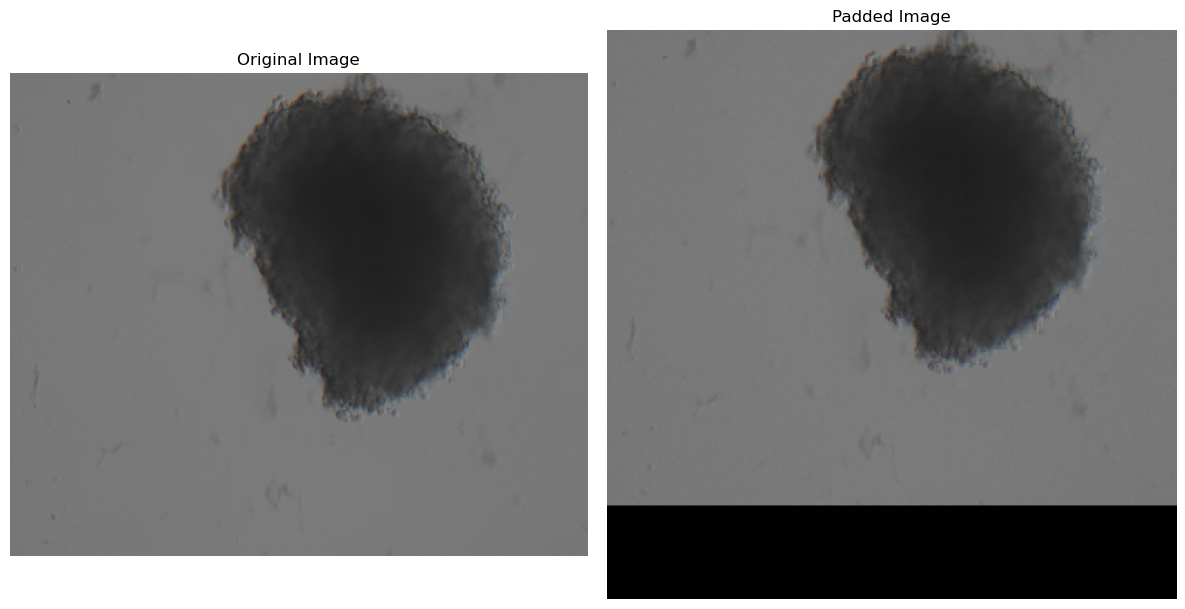

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tifffile as tiff  # Import tifffile for reading TIFF images

# Function to resize with aspect ratio while padding
def resize_with_aspect_ratio(image, target_size):
    # Get original dimensions
    h, w = image.shape[1], image.shape[2]  # Assuming image shape is (C, H, W)
    aspect_ratio = w / h
    
    if aspect_ratio > 1:  # Wider than tall
        new_w = target_size
        new_h = int(target_size / aspect_ratio)
    else:  # Taller than wide or square
        new_h = target_size
        new_w = int(target_size * aspect_ratio)

    # Resize using F.interpolate
    resized_image = torch.nn.functional.interpolate(
        image.unsqueeze(0), size=(new_h, new_w), mode='bilinear', align_corners=False
    ).squeeze(0)

    # Create a padded image
    padded_image = torch.zeros((3, target_size, target_size))  # Create an empty image of target size
    padded_image[:, :new_h, :new_w] = resized_image  # Place resized image in the top-left corner

    return padded_image

# Load the image
img_path = r'C:\Users\k54739\Bibin Babu\thesis\Data_supervised\drug_screened\B02-T01.tiff'
image = tiff.imread(img_path)

# Print the shape of the loaded image
print(f"Image shape: {image.shape}")

# Ensure the image has 3 layers (channels)
if image.shape[0] != 3:
    raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
# Normalize the 16-bit image to [0, 1]
original_image = image.astype(np.float32) / 65535.0
print(f"Normalized image shape: {original_image.shape}")

# Convert to a torch tensor 
image_tensor = torch.tensor(original_image, dtype=torch.float32)

# Resize with aspect ratio and pad
padded_image = resize_with_aspect_ratio(image_tensor, 256)
print(f"Padded image shape: {padded_image.shape}")

# Convert padded tensor back to numpy array for visualization
np_image = padded_image.numpy()

# Plot the original and padded images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display original image
axes[0].imshow(np.transpose(original_image, (1, 2, 0)))  # Transpose for matplotlib
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display padded image
axes[1].imshow(np.transpose(np_image, (1, 2, 0)))  # Transpose for matplotlib
axes[1].set_title('Padded Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [13]:
dataset = ImageDataset(r"../../tiff_experiment_unsupervised_data/combined")
for i in range(len(dataset)):
    falttened_image = dataset[i]  # This will print the shape of each image
    break

import numpy as np
import matplotlib.pyplot as plt

# Load an example dataset that we will be using
def load_data():
    return np.random.rand(300, 2) * 10  # 300 data points with 2 features

# Function for random initialization of centroids
def kMeans_init_centroids(X, K):
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K]]
    return centroids

# Function to find the closest centroids
def find_closest_centroids(X, centroids):
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        distances = np.linalg.norm(X[i] - centroids, axis=1)
        idx[i] = np.argmin(distances)
    return idx

# Function to compute new centroids
def compute_centroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))  # Use shape[1] for features
    for k in range(K):
        points = X[idx == k]
        centroids[k] = np.mean(points, axis=0) if len(points) > 0 else centroids[k]
    return centroids

# Function to run K-Means algorithm
def run_kMeans(X, initial_centroids, max_iters=10):
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros(X.shape[0])
    centroids_history = []

    for i in range(max_iters):
        print(f"K-Means iteration {i}/{max_iters - 1}")
        # Assign each data point to the closest centroid
        idx = find_closest_centroids(X, centroids)
        # Store the current centroids
        centroids_history.append(centroids.copy())
        # Compute new centroids
        centroids = compute_centroids(X, idx, K)

    # Final plot after all iterations
    plot_progress_kMeans(X, centroids_history, idx, K)
    return centroids, idx

# Updated plotting function
def plot_progress_kMeans(X, centroids_history, idx, K):
    plt.figure(figsize=(8, 6))
    
    # Get colors for each cluster
    colors = plt.cm.rainbow(np.linspace(0, 1, K))
    
    # Plot data points with colors based on their final assignments
    plt.scatter(X[:, 0], X[:, 1], c=colors[idx], alpha=0.6)

    # Plot all centroid movements
    for k in range(K):
        for i in range(len(centroids_history) - 1):
            plt.plot([centroids_history[i][k, 0], centroids_history[i + 1][k, 0]], 
                     [centroids_history[i][k, 1], centroids_history[i + 1][k, 1]], 
                     'k--')  # Draw dashed lines

        # Plot the last centroid position
        plt.scatter(centroids_history[-1][k, 0], centroids_history[-1][k, 1], marker='x', s=200, c='k', label='Final Centroids' if k == 0 else "")

    plt.title("K-Means Clustering Progress")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid()
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)
    plt.show()

# Main function to run the K-Means algorithm
X = load_data()                 # Step 1: Load dataset
K = 3                           # Step 2: Set number of clusters
initial_centroids = kMeans_init_centroids(X, K)  # Step 3: Initialize centroids
max_iters = 10                  # Step 4: Number of iterations
centroids, idx = run_kMeans(X, initial_centroids, max_iters)  # Step 5: Run K-Means
print("Final centroids:", centroids)  # Output the final centroids


In [5]:
X.shape

(300, 2)

In [6]:
centroids.shape

(3, 2)

In [7]:
idx

array([0, 1, 0, 1, 1, 2, 2, 0, 1, 1, 1, 0, 2, 0, 2, 2, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 2, 1, 1, 2, 2, 0, 1, 2, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       2, 1, 2, 1, 2, 1, 2, 0, 0, 1, 2, 2, 0, 1, 0, 2, 1, 2, 1, 2, 1, 0,
       2, 1, 2, 0, 2, 0, 0, 2, 0, 2, 0, 1, 2, 0, 0, 0, 2, 2, 2, 1, 0, 1,
       2, 0, 1, 2, 1, 0, 0, 2, 1, 2, 0, 2, 0, 2, 2, 1, 1, 1, 0, 2, 0, 0,
       0, 1, 2, 2, 0, 2, 1, 1, 1, 2, 1, 1, 1, 0, 0, 2, 0, 0, 1, 1, 2, 1,
       1, 0, 2, 2, 2, 2, 0, 0, 0, 1, 1, 2, 2, 1, 1, 2, 0, 2, 0, 2, 2, 2,
       1, 0, 2, 1, 0, 2, 2, 0, 1, 2, 2, 1, 2, 2, 1, 1, 2, 0, 0, 0, 1, 0,
       2, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0,
       0, 2, 1, 0, 0, 0, 1, 2, 0, 2, 0, 1, 1, 2, 1, 1, 2, 0, 0, 0, 1, 0,
       2, 0, 2, 0, 2, 2, 1, 1, 2, 0, 1, 0, 2, 2, 0, 1, 2, 2, 0, 1, 0, 1,
       0, 2, 0, 1, 1, 1, 1, 0, 0, 1, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 1, 0,
       0, 2, 0, 2, 0, 0, 0, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 0, 2, 1, 2, 1,
       1, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0])

In [8]:
idx.shape

(300,)